# Neural translation - seq2seq
## French questions to english questions

**Difficulties:**

1. Output of arbitrary length
1. Order of tokens in the input and the output is not the same

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

## Dataset
http://www.statmt.org/wmt15/translation-task.html

Obtained by web crawling millions of sites and using simple heuristics such as replacing *en* with *fr* etc.

In [3]:
PATH = Path('data/translate/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
filename = 'giga-fren.release2.fixed'

In [5]:
en_fn = PATH/f'{filename}.en'
fr_fn = PATH/f'{filename}.fr'

Training a full translation model takes a long time. In this example we therefore focus only on questions that start with *What*, *Where*, *Wh...* etc. and end with a *?*.

Compiling makes the regular expressions faster.

In [6]:
re_enquest = re.compile('^(Wh[^?.!]+\?)')
re_frquest = re.compile('^([^?.!]+\?)')

In [7]:
lines = ((re_enquest.search(enquest), re_frquest.search(frquest)) for enquest, frquest in zip(open(en_fn, encoding='utf-8'), open(fr_fn, encoding='utf-8')))

In [8]:
for i, l in enumerate(lines):
    print(l)
    if i == 20:
        break

(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(<_sre.SRE_Match object; span=(0, 15), match='What is light ?'>, <_sre.SRE_Match object; span=(0, 25), match='Qu’est-ce que la lumière?'>)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, <_sre.SRE_Match object; span=(0, 72), match="Astronomes Introduction Vidéo d'introduction Qu'e>)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(<_sre.SRE_Match object; span=(0, 11), match='Who are we?'>, <_sre.SRE_Match object; span=(0, 15), match='Où sommes-nous?'>)
(<_sre.SRE_Match object; span=(0, 23), match='Where did we come from?'>, <_sre.SRE_Match object; span=(0, 17), match="D'où venons-nous?">)


In [9]:
questions = [(e.group(), f.group()) for e, f in lines if e and f]

In [10]:
pickle.dump(questions, (PATH/'fr-en-questions.pkl').open('wb'))

In [11]:
questions = pickle.load((PATH/'fr-en-questions.pkl').open('rb'))

In [12]:
questions[:3]

[('What would we do without it?', 'Que ferions-nous sans elle ?'),
 ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
  'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?'),
 ('What is the major aboriginal group on Vancouver Island?',
  'Quel est le groupe autochtone principal sur l’île de Vancouver?')]

In [13]:
len(questions)

52328

In [14]:
en_questions, fr_questions = zip(*questions)

### Tokenization

`Tokenizer` is a fastai wrapper around *spacy* that uses multiple processors for speedup.

In [15]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_questions))

In [16]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_questions), 'fr')

In [17]:
en_tok[0]

['what', 'would', 'we', 'do', 'without', 'it', '?']

In [18]:
fr_tok[0]

['que', 'ferions', '-', 'nous', 'sans', 'elle', '?']

#### Average length of the questions

In [19]:
np.mean([len(q) for q in en_tok])

13.345895123069868

In [20]:
np.mean([len(q) for q in fr_tok])

16.26809738572084

#### Discard questions that are too long

In [21]:
keep = np.array([len(q) < 30 for q in en_tok])

In [22]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [23]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [24]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

### Numericalization

In [25]:
def toks2idxs(tok, pre):
    freq = Counter(t for q in tok for t in q)
    itos = [s for s, c in freq.most_common(40000)]
    itos.insert(0, '_bos_')  # beginning of sequence token
    itos.insert(1, '_pad_')  # padding token
    itos.insert(2, '_eos_')  # end of sequence token
    itos.insert(3, '_unk_')  # unknown token
    stoi = collections.defaultdict(lambda: 3, {t:i for i,t in enumerate(itos)})  # if string not found, set to '_unk_'
    indcs = np.array([([stoi[t] for t in q] + [2]) for q in tok])
    np.save(TMP_PATH/f'{pre}_indcs.npy', indcs)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos_pkl', 'wb'))
    return indcs, itos, stoi

In [26]:
en_indcs, en_itos, fr_stoi = toks2idxs(en_tok, 'en')

In [27]:
fr_indcs, fr_itos, fr_stoi = toks2idxs(fr_tok, 'fr')

In [28]:
def load_indcs(pre):
    indcs = np.load(TMP_PATH/f'{pre}_indcs.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos_pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {t:i for i,t in enumerate(itos)})
    return indcs, itos, stoi

In [29]:
en_indcs, en_itos, en_stoi = load_indcs('en')
fr_indcs, fr_itos, fr_stoi = load_indcs('fr')

In [30]:
' '.join([en_itos[i] for i in en_indcs[0]])

'what would we do without it ? _eos_'

In [31]:
' '.join([fr_itos[i] for i in fr_indcs[0]])

'que ferions - nous sans elle ? _eos_'

### Word vectors

In [32]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [33]:
import fastText as ft

In [34]:
en_vecs = ft.load_model(str((PATH/'word_vectors'/'wiki.en.bin')))

In [35]:
fr_vecs = ft.load_model(str(PATH/'word_vectors'/'wiki.fr.bin'))

In [36]:
def get_vecs(lang, ft_vecs):
    vec_dict = {w: ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vec_dict, open(PATH/f'wiki.{lang}.pkl', 'wb'))
    return vec_dict

In [37]:
en_vec_dict = get_vecs('en', en_vecs)
fr_vec_dict = get_vecs('fr', fr_vecs)

In [38]:
en_vec_dict = pickle.load(open(PATH/'wiki.en.pkl','rb'))
en_vec_dict = pickle.load(open(PATH/'wiki.en.pkl','rb'))

In [39]:
ft_words = en_vecs.get_words(include_freq=True)

In [40]:
ft_word_dict = {k:v for k,v in zip(*ft_words)}

In [41]:
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])  # sorted by frequency

In [42]:
ft_words[-20:]

['by',
 'as',
 'for',
 's',
 'on',
 'was',
 'is',
 'a',
 'to',
 '(',
 ')',
 "'",
 'and',
 'in',
 '-',
 'of',
 '</s>',
 'the',
 '.',
 ',']

In [43]:
len(ft_words)

2519370

#### Dimensionality of the word vectors

In [44]:
dim_en_vec = len(en_vec_dict['and'])
dim_fr_vec = len(fr_vec_dict['and'])

In [45]:
dim_en_vec, dim_fr_vec

(300, 300)

#### Mean and stdv of word vectors

In [46]:
en_vecs = np.stack(list(en_vec_dict.values()))
# keys are words, values are the vectors of size 300

In [47]:
en_vecs.shape

(2519370, 300)

In [48]:
en_vecs.mean(), en_vecs.std()

(0.0075652334, 0.29283327)

### Model data object

`en_indcs` are the numericalized questions.

**Percentile:**
*Ist beispielsweise eine Stichprobe von Schuhgrößen gegeben, so ist das empirische 0,35-Quantil diejenige Schuhgröße s , so dass 35 % der Schuhgrößen in der Stichprobe kleiner als s  sind und 65 % größer als s sind.* [source](https://de.wikipedia.org/wiki/Empirisches_Quantil)

In [49]:
en_len_99 = int(np.percentile([len(o) for o in en_indcs], 99))
fr_len_97 = int(np.percentile([len(o) for o in fr_indcs], 97))

In [50]:
en_len_99, fr_len_97

(29, 33)

#### Truncate the questions

In [51]:
en_indcs_trunc = np.array([q[:en_len_99] for q in en_indcs])
fr_indcs_trunc = np.array([q[:fr_len_97] for q in fr_indcs])

A `Dataset` object needs a `__getitem__` and a `__len__` method. This example is actually very general and can be used for any arrays...

In [52]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __getitem__(self, idx):
        return A(self.x[idx], self.y[idx])
    def __len__(self):
        return len(self.x)

In [53]:
??A()  # returns a np.array if len == 1 else returns a list of np.arrays

In [54]:
np.random.seed(42)

#### Split into train and validation set

In [55]:
trn_keep = np.random.rand(len(en_indcs_trunc)) > 0.1

In [56]:
en_trn, fr_trn = en_indcs_trunc[trn_keep], fr_indcs_trunc[trn_keep]

In [57]:
en_val, fr_val = en_indcs_trunc[~trn_keep], fr_indcs_trunc[~trn_keep]  # tilde negates

In [58]:
len(en_trn), len(en_val)

(45218, 5039)

#### Create datasets for french to english translation. Swap arguments to create a english to french model.

In [59]:
trn_ds = Seq2SeqDataset(fr_trn, en_trn)
val_ds = Seq2SeqDataset(fr_val, en_val)

In [60]:
' '.join([fr_itos[o] for o in fr_trn[0]])

'que ferions - nous sans elle ? _eos_'

In [61]:
' '.join([en_itos[o] for o in en_trn[0]])

'what would we do without it ? _eos_'

Everything still looking as expected :)

In [62]:
bs = 125

Since we want to fully utilize the GPUs capabilities, we train in batches. The length of a minibatch tensor is set by the sequence length of the longest question in that batch. The other questions are padded. To save time and memory, we want to avoid very long and very short questions in one batch because that would mean lot's of padding. For the validation set we simply sort the questions. For training we use the `SortishSampler` which groups *longer* questions together and *shorter* questions together while preserving some randomness.

For language models it's better to pad before the start of the sequence because we need the final hidden state to predict the next token or for classification...

For sequence to sequence models it is better to pad after the end of the sequence.

In [63]:
trn_sampler = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_sampler = SortSampler(en_val, key=lambda x:len(en_val[x]))

Both samplers simply return indices:

In [64]:
i = next(iter(trn_sampler))

In [65]:
' '.join([en_itos[o] for o in en_trn[i]])

'why do birds live near the ocean ? _eos_'

In [66]:
' '.join([fr_itos[o] for o in fr_trn[i]])

'pourquoi certains oiseaux vivent - ils à proximité de la mer ? _eos_'

In [67]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False, sampler=trn_sampler)


In [68]:
val_dl = DataLoader(val_ds, int(1.5*bs), transpose=True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False, sampler=val_sampler)

Reminder: the ModelData object combines the training and validation dataloaders and a path to story temp stuff. When you have a ModelData object you can create a learner and then call `fit`.

In [69]:
modeldata = ModelData(PATH, trn_dl, val_dl)

**Let's look at an example batch:**

In [70]:
it = iter(trn_dl)
its = [next(it) for i in range(3)]

In [71]:
[(len(x), len(y)) for x,y in its]

[(32, 18), (25, 8), (21, 9)]

In [72]:
for x, y in its:
    print(' '.join([fr_itos[o] for o in x[:,0]]))
    print(' '.join([en_itos[o] for o in y[:,0]]))
    print()

en ce qui concerne l’ adhésion des 10 nouveaux états membres , quelle est la proposition correcte ? _eos_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_
which of the following is correct as regards the accession of the 10 new member states ? _eos_

quels stimulateurs de croissance sont autorisés au canada ? _eos_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_
which products are approved in canada ? _eos_

qui a -t -on atteint avec le programme ? _eos_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_
who has been reached by the program ? _eos_



## First model

In [73]:
n_hid, n_layers = 256, 2

In [74]:
def create_emb(wordvecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)  # wordvecs is a dict
            # wordvecs have stdv of ~0.3, embedding of 1, the found and not found ones should have same stdv
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

In [75]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, emb_sz_enc, vecs_dec, itos_dec, emb_sz_dec, nh, out_seqlen, nl=2):
        super().__init__()
        self.nh, self.nl, self.out_seqlen = nh, nl, out_seqlen
        
        # Encoder
        self.emb_enc = create_emb(vecs_enc, itos_enc, emb_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz_enc, nh, num_layers=nl, dropout=0.25)  # sz 300 in, sz 256 out
        self.outp_enc = nn.Linear(nh, emb_sz_dec, bias=False)               # sz 256 in, sz 300 out
        
        # Decoder
        self.emb_dec = create_emb(vecs_dec, itos_dec, emb_sz_dec)
        self.rnn_dec = nn.GRU(emb_sz_dec, emb_sz_dec, num_layers=nl, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)                                           # sz 300 in, 300 out
        self.out = nn.Linear(emb_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data                            # weight tying! not transposed?
        
    def forward(self, inp):
        seqlen, bs = inp.size()
        
        # Encoder
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_outp, h = self.rnn_enc(emb, h)  # h[1] is same as enc_outp[-1]!
        # pdb.set_trace()
        h = self.outp_enc(h)

        # Decoder
        dec_inp = V(torch.zeros(bs).long())  # 0 is 'beginning of seq' token
        res = []
        for i in range(self.out_seqlen):
            emb = self.emb_dec(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
            outp, h = self.rnn_dec(emb, h)  # 'loops' once
            outp = self.out(self.out_drop(outp[0]))  # 0 because 'loops' once, predictions for words
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  # [1] to get argmax
            if (dec_inp == 1).all(): break    # if all sentences in the minibatch have _pad_ as input, break
        return torch.stack(res)
        
    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))

**Decoder:** `outp`is the same as `h[1]` (has two layers)
```
p outp.shape
torch.Size([1, 187, 300])

p h.shape
torch.Size([2, 187, 300])
```

**Encoder:**
```
p enc_outp.shape
torch.Size([33, 187, 256])

p h.shape
torch.Size([2, 187, 256])
```

`enc_outp[-1]` and `h[1]` are the same

(187 is bs)

### Loss function

In [76]:
def Seq2SeqLoss(pred, target):
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    return F.cross_entropy(pred.view(-1, n_probs), target.view(-1))

In [77]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [78]:
dim_fr_vec, dim_en_vec

(300, 300)

In [115]:
rnn = Seq2SeqRNN(fr_vec_dict, fr_itos, dim_fr_vec, en_vec_dict, en_itos, dim_en_vec, n_hid, en_len_99)

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


#### It's kind of understandable that these tokens where not found in the word vectors we downloaded

In [116]:
learn = Learner(modeldata, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)  # SingleModel makes the model one layer group

In [117]:
learn.crit = Seq2SeqLoss

In [94]:
learn.lr_find()

 67%|██████▋   | 241/362 [00:23<00:12, 10.06it/s, loss=37.1]

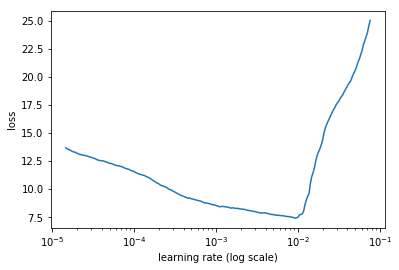

In [95]:
learn.sched.plot()

In [96]:
lr = 3e-3

In [97]:
learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20, 10))

 14%|█▍        | 52/362 [00:05<00:30, 10.00it/s, loss=8.32]
epoch      trn_loss   val_loss                              
    0      5.44016    5.701974  
    1      4.310874   4.549533                              
    2      3.890306   4.157954                              
    3      3.719702   4.019643                              
    4      3.322341   3.865383                              
    5      3.221692   3.795207                              
    6      3.220406   3.697457                              
    7      3.244708   3.7222                                
    8      2.893455   3.646579                              
    9      2.846069   3.616925                              
    10     2.784473   3.573879                              
    11     2.667841   3.572502                              



[3.572502047460784]

In [98]:
learn.save('first_model')

In [118]:
learn.load('first_model')

### Test the model

In [79]:
import itertools

In [163]:
x, y = next(itertools.islice(iter(val_dl), 25, None))
probs = learn.model(V(x))

In [164]:
probs.shape

torch.Size([18, 187, 17573])

In [165]:
preds = to_np(probs.max(2)[1])

In [167]:
start = 110
for i in range(start, start + 10):
    print(' '.join([fr_itos[o] for o in x[:, i] if o != 1]))  # Input
    print(' '.join([en_itos[o] for o in y[:, i] if o != 1]))  # Target
    print(' '.join([en_itos[o] for o in preds[:, i] if o != 1]))  # Prediction
    print()

qu' est ce que l ' t_up ipv ? _eos_
what is t_up api ? _eos_
what is the t_up ? _eos_

qu' entend - on par autres méthodes de déclaration ? _eos_
what is alternate reporting ? _eos_
what are other other ? ? _eos_

que montrent - elles ? _eos_
what does it show ? _eos_
what do they do ? _eos_

qui est en conflit ? _eos_
who is in conflict ? _eos_
who is conflict ? _eos_

pourquoi encourager davantage la recherche ? _eos_
why encourage more research ? _eos_
why encourage more promote research ? _eos_

qui sont les vulnérables ? _eos_
who are the vulnerable ? _eos_
who are vulnerable ? ?

pourquoi encourager davantage la recherché ? _eos_
why encourage more research ? _eos_
why encourage we more ? _eos_ _eos_

qu’ est -ce que des données identifiables ? _eos_
what is identifiable data ? _eos_
what is the ? ? _eos_

pourquoi était - il l' adversaire de sir john ? _eos_
why were they opponents ? _eos_
why was he shoemaker ’s ? ? _eos_

qu' est -ce que l' admissibilité partagée ? _eos_
what 

## Bidirectional encoder

In [168]:
class Seq2SeqRNNBidirectional(nn.Module):
    def __init__(self, vecs_enc, itos_enc, emb_sz_enc, vecs_dec, itos_dec, emb_sz_dec, nh, out_seqlen, nl=2):
        super().__init__()
        self.nh, self.nl, self.out_seqlen = nh, nl, out_seqlen
        
        # Encoder
        self.emb_enc = create_emb(vecs_enc, itos_enc, emb_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        # sz 300 in, sz 256 out
        self.outp_enc = nn.Linear(2 * nh, emb_sz_dec, bias=False)  # *2 because of bidirectional
        # sz 256 in, sz 300 out
        self.drop_enc = nn.Dropout(0.05)
        
        # Decoder
        self.emb_dec = create_emb(vecs_dec, itos_dec, emb_sz_dec)
        self.rnn_dec = nn.GRU(emb_sz_dec, emb_sz_dec, num_layers=nl, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)                                           # sz 300 in, 300 out
        self.out = nn.Linear(emb_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data                            # weight tying! not transposed?
        
    def forward(self, inp):
        seqlen, bs = inp.size()
        
        # Encoder
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_outp, h = self.rnn_enc(emb, h)
        # pdb.set_trace()
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.outp_enc(self.drop_enc(h))  # h[1] is same as enc_outp[-1]!

        # Decoder
        dec_inp = V(torch.zeros(bs).long())  # 0 is 'beginning of seq' token
        res = []
        for i in range(self.out_seqlen):
            emb = self.emb_dec(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
            outp, h = self.rnn_dec(emb, h)  # 'loops' once
            outp = self.out(self.out_drop(outp[0]))  # 0 because 'loops' once, predictions for words
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  # [1] to get argmax
            if (dec_inp == 1).all(): break    # if all sentences in the minibatch have _pad_ as input, break
        return torch.stack(res)
        
    def initHidden(self, bs):
        return V(torch.zeros(self.nl * 2, bs, self.nh))  # because of bidirectional

In [171]:
rnn = Seq2SeqRNN(fr_vec_dict, fr_itos, dim_fr_vec, en_vec_dict, en_itos, dim_en_vec, n_hid, en_len_99)
learn = Learner(modeldata, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = Seq2SeqLoss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [172]:
learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20, 10))

epoch      trn_loss   val_loss                              
    0      5.267118   5.180488  
    1      4.31144    4.448733                              
    2      3.889166   4.067809                              
    3      3.632571   3.874861                              
    4      3.259331   3.805607                              
    5      3.262788   3.709997                              
    6      3.083301   3.682233                              
    7      3.000043   3.629029                              
    8      3.079843   3.577867                              
    9      2.810955   3.538162                              
    10     2.795676   3.544407                              
    11     2.611297   3.525392                              



[3.525392242647567]

Without bidirectional the final loss was 3.57

In [ ]:
learn.save('bidirectional_model')

In [ ]:
learn.load('bidirectional_model')

## Teacher forcing (without bidirectional for now)
**Idea:** Especially in the beginning the model predicts only garbage. Let's kickstart training by whispering some answers to it just as a teacher might do during an oral exam.

We reduce the teacher forcing probability over time. In order to do that we create a new `Seq2SeqStepper` and override the `step` method of `Stepper`.

In [80]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        # This line implements the decay of the teacher forcing prob
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        
        # The rest ist just the stepper method from the library
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [187]:
class Seq2SeqRNNTeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, emb_sz_enc, vecs_dec, itos_dec, emb_sz_dec, nh, out_seqlen, nl=2):
        super().__init__()
        self.nh, self.nl, self.out_seqlen = nh, nl, out_seqlen
        
        # Encoder
        self.emb_enc = create_emb(vecs_enc, itos_enc, emb_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz_enc, nh, num_layers=nl, dropout=0.25)  # sz 300 in, sz 256 out
        self.outp_enc = nn.Linear(nh, emb_sz_dec, bias=False)               # sz 256 in, sz 300 out
        
        # Decoder
        self.emb_dec = create_emb(vecs_dec, itos_dec, emb_sz_dec)
        self.rnn_dec = nn.GRU(emb_sz_dec, emb_sz_dec, num_layers=nl, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)                                           # sz 300 in, 300 out
        self.out = nn.Linear(emb_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data                            # weight tying! not transposed?
        
        self.pr_force = 1. ### Teacher forcing ###
        
    def forward(self, inp, y=None):
        seqlen, bs = inp.size()
        
        # Encoder
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_outp, h = self.rnn_enc(emb, h)
        # pdb.set_trace()
        h = self.outp_enc(h)  # h[1] is same as enc_outp[-1]!

        # Decoder
        dec_inp = V(torch.zeros(bs).long())  # 0 is 'beginning of seq' token
        res = []
        for i in range(self.out_seqlen):
            emb = self.emb_dec(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
            outp, h = self.rnn_dec(emb, h)  # 'loops' once
            outp = self.out(self.out_drop(outp[0]))  # 0 because 'loops' once, predictions for words
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  # [1] to get argmax
            if (dec_inp == 1).all(): break    # if all sentences in the minibatch have _pad_ as input, break
                
            if (y is not None) and (random.random() < self.pr_force):
                if i >= len(y): break  # predicted seq is already longer than y => nothing to whisper
                dec_inp = y[i]         ### Teacher forcing ###
            
        return torch.stack(res)
        
    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))

In [190]:
rnn = Seq2SeqRNNTeacherForcing(fr_vec_dict, fr_itos, dim_fr_vec, en_vec_dict, en_itos, dim_en_vec, n_hid, en_len_99)
learn = Learner(modeldata, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = Seq2SeqLoss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [191]:
learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20, 10), stepper=Seq2SeqStepper)

  1%|          | 3/362 [00:00<00:35,  9.99it/s, loss=tensor(10.9706, device='cuda:0')]

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch      trn_loss   val_loss                                                         
    0      3.798883   11.010717 
    1      3.230599   7.161752                                                         
    2      3.058165   5.452962                                                         
    3      3.285037   4.634273                                                         
    4      2.992541   4.289666                                                         
    5      2.89953    4.058496                                                         
    6      2.951971   3.809111                                                         
    7      2.826471   3.737335                                                         
    8      2.820316   3.596977                                                         
    9      3.075896   3.557067                                                         
    10     2.818115   3.518843                                                         

[3.508829193894968]

1. Without bidirectional and teacher forcing the final loss was 3.57
1. Without teacher forcing but with bidirectional the final loss was 3.525

Interesting question: why is the validation loss so high initially compared to the previous tries?

In [192]:
learn.save('teacher_forcing_model')

In [193]:
learn.load('teacher_forcing_model')

## Attention

In [83]:
def random_tensor(*sz):
    return torch.randn(sz)/math.sqrt(sz[0])  # division by sqrt is initialization
def random_param(*sz):
    return nn.Parameter(random_tensor(*sz))

In [341]:
class Seq2SeqRNNAttentionModel(nn.Module):
    def __init__(self, vecs_enc, itos_enc, emb_sz_enc, vecs_dec, itos_dec, emb_sz_dec, nh, out_seqlen, nl=2):
        super().__init__()
        self.nh, self.nl, self.out_seqlen = nh, nl, out_seqlen
        
        # Encoder
        self.emb_enc = create_emb(vecs_enc, itos_enc, emb_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.outp_enc = nn.Linear(nh, emb_sz_dec, bias=False)
        
        # Decoder
        self.emb_dec = create_emb(vecs_dec, itos_dec, emb_sz_dec)
        self.rnn_dec = nn.GRU(emb_sz_dec, emb_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(emb_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data  # weight tying!
        
        # Attention
        self.W1 = random_param(nh, emb_sz_dec)
        self.l2 = nn.Linear(emb_sz_dec, emb_sz_dec)
        self.l3 = nn.Linear(emb_sz_dec + nh, emb_sz_dec)
        self.V = random_param(emb_sz_dec)
        
        self.pr_force = 1. ### Teacher forcing ###
        
    def forward(self, inp, y=None, ret_attn=False):
        seqlen, bs = inp.size()
        
        # Encoder
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_outp, h = self.rnn_enc(emb, h)  # h[1] is same as enc_outp[-1]!
        h = self.outp_enc(h)  # from hidden size to emb_sz_dec
        
        dec_inp = V(torch.zeros(bs).long())  # '_bos_' token for every seq in minibatch
        res, attns = [], []
        # See Luong et al 2015 section 3.1 equation 'score(h_t, \bar h_s)'
        # Multiply all hidden states (\bar h_s) of the encoder with Matrix W_alpha
        w1 = enc_outp @ self.W1
        # I think that this implementation is slightly different from concat in Luong et al 2015
        # because they concat the hidden states and then apply a single matrix multiplication.
        # Here we have two different matrices with output size emb_sz_dec, apply them first
        # and then concatenate
        for i in range(self.out_seqlen):
            
            # Attention
            w2 = self.l2(h[-1])  # $W_alpha$ times $h_t$ in Luong et al
            u = F.tanh(w1 + w2)
            a = F.softmax(u @ self.V, 0)  # See equation 7 in Luong et al, V is $v_a^T$
            
            attns.append(a)
            c_t = (a.unsqueeze(2) * enc_outp).sum(0)  # context vector = weighted sum of encoder hidden states
            
            emb = self.emb_dec(dec_inp)
            
            weighted_enc = self.l3(torch.cat([emb, c_t], 1))  
            
            # ATTENTION
            # In the Luong et al Paper things are slightly different
            # the context vector c_t and the current decoder hidden state
            # are concat together and then fed into a linear layer with tanh activation.
            # The result called attentional hidden state is fed into a second linear layer with softmax
            # activation which gives the probabilities for every token.
            
            # The fastai implementation takes the context vector c_t, concats it with the INPUT
            # of the decoder (dec_inp) and feeds this into a linear layer.
            # This input (dec_inp) that is 'mixed' with the context vector 
            # is then fed into the decoder rnn. The hidden state that is fed into
            # the decoder rnn is NOT 'mixed' with the context vector as opposed to Long et al 2015
            
            outp, h = self.rnn_dec(weighted_enc.unsqueeze(0), h)  # 'loops' once because of unsqueeze(0)
            outp = self.out(self.out_drop(outp[0]))  # 0 because 'loops' once, predictions for words
            res.append(outp)
            
            dec_inp = V(outp.data.max(1)[1])  # [1] to get argmax
            
            if (dec_inp == 1).all(): break
            if (y is not None) and (random.random() < self.pr_force):
                if i >= len(y): break  # predicted seq is already longer than y => nothing to whisper
                dec_inp = y[i]         ### Teacher forcing ###    
            
        res = torch.stack(res)
        if ret_attn: res = res, torch.stack(attns)
        return res
        
    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))  # if all sentences in the minibatch have _pad_ as input, break

In [342]:
rnn = Seq2SeqRNNAttentionModel(fr_vec_dict, fr_itos, dim_fr_vec, en_vec_dict, en_itos, dim_en_vec, n_hid, en_len_99)
learn = Learner(modeldata, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = Seq2SeqLoss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [87]:
lr = 2e-3

In [344]:
learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20, 10), stepper=Seq2SeqStepper)

  0%|          | 1/362 [00:00<01:10,  5.10it/s, loss=tensor(9.8161, device='cuda:0')]

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 14%|█▎        | 49/362 [00:03<00:22, 13.88it/s, loss=tensor(6.9882, device='cuda:0')]
epoch      trn_loss   val_loss                                                         
    0      4.191049   14.424263 
    1      3.060529   5.687311                                                         
    2      3.068104   5.495779                                                         
    3      2.772898   4.794846                                                         
    4      2.817782   4.081442                                                         
    5      2.894404   4.314808                                                         
    6      2.759051   3.80134                                                          
    7      2.73077    3.705336                                                         
    8      2.769924   3.509056                                                         
    9      2.944073   3.422912                                                         


[3.3660999226120283]

1. Without bidirectional and teacher forcing the final loss was 3.57
1. Without teacher forcing but with bidirectional the final loss was 3.525
1. With teacher forcing but without bidirectional the final loss was 3.508829

Now we are down to 3.366.

Now, let's combine all methods

In [346]:
learn.save('attention_model')

In [347]:
learn.load('attention_model')

## Bidirectional, teacher forcing, and Attention

In [84]:
class Seq2SeqRNNAll(nn.Module):
    def __init__(self, vecs_enc, itos_enc, emb_sz_enc, vecs_dec, itos_dec, emb_sz_dec, nh, out_seqlen, nl=2):
        super().__init__()
        self.nh, self.nl, self.out_seqlen = nh, nl, out_seqlen
        
        # Encoder
        self.emb_enc = create_emb(vecs_enc, itos_enc, emb_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.drop_enc = nn.Dropout(0.25)
        self.outp_enc = nn.Linear(2 * nh, emb_sz_dec, bias=False)
     
        # Decoder
        self.emb_dec = create_emb(vecs_dec, itos_dec, emb_sz_dec)
        self.rnn_dec = nn.GRU(emb_sz_dec, emb_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(emb_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data  # weight tying!
        
        # Attention
        self.W1 = random_param(2 * nh, emb_sz_dec)
        self.l2 = nn.Linear(emb_sz_dec, emb_sz_dec)
        self.l3 = nn.Linear(emb_sz_dec + nh * 2, emb_sz_dec)
        self.V = random_param(emb_sz_dec)
        
        self.pr_force = 1. ### Teacher forcing ###
        
    def forward(self, inp, y=None, ret_attn=False):
        seqlen, bs = inp.size()
        
        # Encoder
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_outp, h = self.rnn_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.outp_enc(self.drop_enc(h))
        
        dec_inp = V(torch.zeros(bs).long())  # '_bos_' token for every seq in minibatch
        res, attns = [], []
        # See Luong et al 2015 section 3.1 equation 'score(h_t, \bar h_s)'
        # Multiply all hidden states (\bar h_s) of the encoder with Matrix W_alpha
        w1 = enc_outp @ self.W1
        # I think that this implementation is slightly different from concat in Luong et al 2015
        # because they concat the hidden states and then apply a single matrix multiplication.
        # Here we have two different matrices with output size emb_sz_dec, apply them first
        # and then concatenate
        for i in range(self.out_seqlen):
            
            # Attention
            w2 = self.l2(h[-1])  # $W_alpha$ times $h_t$ in Luong et al
            u = F.tanh(w1 + w2)
            a = F.softmax(u @ self.V, 0)  # See equation 7 in Luong et al, V is $v_a^T$
            
            attns.append(a)
            c_t = (a.unsqueeze(2) * enc_outp).sum(0)  # context vector = weighted sum of encoder hidden states
            
            emb = self.emb_dec(dec_inp)
            
            weighted_enc = self.l3(torch.cat([emb, c_t], 1))  
            
            # ATTENTION
            # In the Luong et al Paper things are slightly different
            # the context vector c_t and the current decoder hidden state
            # are concat together and then fed into a linear layer with tanh activation.
            # The result called attentional hidden state is fed into a second linear layer with softmax
            # activation which gives the probabilities for every token.
            
            # The fastai implementation takes the context vector c_t, concats it with the INPUT
            # of the decoder (dec_inp) and feeds this into a linear layer.
            # This input (dec_inp) that is 'mixed' with the context vector 
            # is then fed into the decoder rnn. The hidden state that is fed into
            # the decoder rnn is NOT 'mixed' with the context vector as opposed to Long et al 2015
            
            outp, h = self.rnn_dec(weighted_enc.unsqueeze(0), h)  # 'loops' once because of unsqueeze(0)
            outp = self.out(self.out_drop(outp[0]))  # 0 because 'loops' once, predictions for words
            res.append(outp)
            
            dec_inp = V(outp.data.max(1)[1])  # [1] to get argmax
            
            if (dec_inp == 1).all(): break
            if (y is not None) and (random.random() < self.pr_force):
                if i >= len(y): break  # predicted seq is already longer than y => nothing to whisper
                dec_inp = y[i]         ### Teacher forcing ###    
            
        res = torch.stack(res)
        if ret_attn: res = res, torch.stack(attns)
        return res
        
    def initHidden(self, bs):
        return V(torch.zeros(2 * self.nl, bs, self.nh))  # if all sentences in the minibatch have _pad_ as input, break

In [89]:
rnn = Seq2SeqRNNAll(fr_vec_dict, fr_itos, dim_fr_vec, en_vec_dict, en_itos, dim_en_vec, n_hid, en_len_99)
learn = Learner(modeldata, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = Seq2SeqLoss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [90]:
learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20, 10), stepper=Seq2SeqStepper)

  0%|          | 1/362 [00:00<01:07,  5.39it/s, loss=tensor(10.5020, device='cuda:0')]

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch      trn_loss   val_loss                                                         
    0      3.432203   9.22238   
    1      3.837512   8.494652                                                         
    2      3.28513    6.461766                                                         
    3      3.276439   5.529211                                                         
    4      3.003907   6.119911                                                         
    5      3.133035   4.014019                                                         
    6      2.863579   3.807283                                                         
    7      2.899184   3.745806                                                         
    8      3.003482   3.547384                                                         
    9      3.096476   3.428664                                                         
    10     2.82979    3.357279                                                         

[3.3252869728976076]

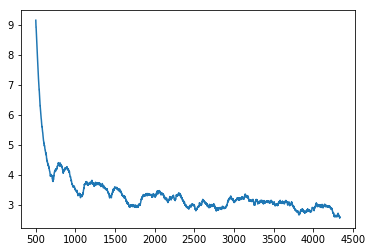

In [126]:
learn.sched.plot_loss(n_skip=500)

## Test

In [216]:
x, y = next(itertools.islice(iter(val_dl), 25, None))
probs, attns = learn.model(V(x), ret_attn=True)

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [217]:
preds = to_np(probs.max(2)[1])

In [218]:
start = 100
for i in range(start, start + 10):
    print(' '.join([fr_itos[o] for o in x[:, i] if o != 1]))  # Input
    print(' '.join([en_itos[o] for o in y[:, i] if o != 1]))  # Target
    print(' '.join([en_itos[o] for o in preds[:, i] if o != 1]))  # Prediction
    print()

pourquoi ? _eos_
why the best source ? _eos_
why ? _eos_

à qui pouvez - vous faire confiance ? _eos_
who can you trust ? _eos_
who can you trust ? ? _eos_

pourquoi ? _eos_
why or why not ? _eos_
why ? _eos_

quels types de projets ? _eos_
what types of projects ? _eos_
what types of projects are _eos_

qui et pourquoi ? _eos_
which ones and why ? _eos_
who and why why why ?

quel est le ratio des étudiants étrangers et canadiens dans votre établissement ? _eos_
why is this important ? _eos_
what is the ratio of of foreign and and in in your institution ? _eos_

qu’ est -ce que l’ intégrité commémorative ? _eos_
what is commemorative integrity ? _eos_
what is integrity integrity ? _eos_

qu’ est -ce que le financement de projet ? _eos_
what is project funding ? _eos_
what is funding project ? _eos_

quels sont les avantages ? _eos_
what are the benefits ? _eos_
what are the benefits ? _eos_

pourquoi l’ inspection est-elle nécessaire ? _eos_
why is inspection necessary ? _eos_
why is 

In [202]:
x, y = next(itertools.islice(iter(val_dl), 21, None))
probs, attns = learn.model(V(x), ret_attn=True)
preds = to_np(probs.max(2)[1])

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [211]:
i = 103
attn = to_np(attns[...,i])
input_sequence = ' '.join([fr_itos[o] for o in x[:, i] if o != 1])
output_words = [en_itos[o] for o in preds[:, i] if o != 1]

In [212]:
input_sequence

"de quel type d' autorisation ai - je besoin ? _eos_"

In [213]:
output_words

['what', 'type', 'of', 'authorization', 'do', 'i', 'need', '?', '_eos_']

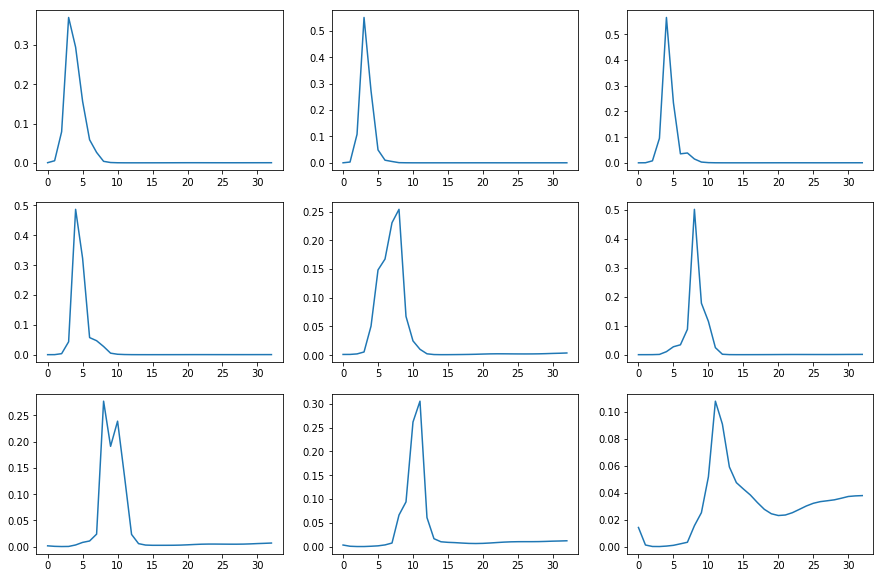

In [214]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

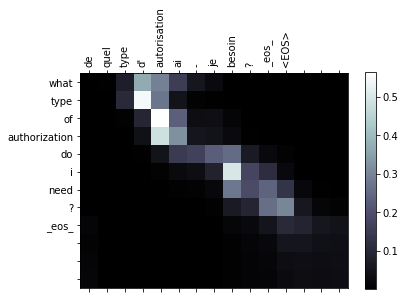

In [224]:
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(attn[:12,:15], cmap='bone')
fig.colorbar(cax)

# axes
ax.set_xticklabels([''] + input_sequence.split(' ') + ['<EOS>'], rotation=90)
ax.set_yticklabels([''] + output_words)
# Show label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

Plot commands for attention from [here](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py).

In [219]:
attn.shape

(28, 33)